In [1]:
library(Seurat)
library(tidyverse)
library(foreach)
library(doParallel)
library(ggpubr)
source("/shareb//zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
library(ComplexHeatmap)
options(bedtools.path = "~/miniconda3/envs/py3/bin")
library(bedtoolsr)
options(scipen=999)

celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6", 
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","early neurons"="#1F62A6","schwann cell precursors"="#08519C",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C","mix late mesenchyme"="#BD342F",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5"
)
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘foreach’


The followin

In [2]:
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/d3D.R") %>% suppressMessages()
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/great.R") %>% suppressMessages()
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R") %>% suppressMessages()
options(bedtools.path = "~/miniconda3/envs/py3/bin/")
library(bedtoolsr)

In [3]:
mm10 <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = F)
names(mm10) <- c("chrom","start","end","id","name","strand")
mm10 <- mm10 %>% mutate(length = end - start) %>% arrange(desc(length)) %>% group_by(name) %>% dplyr::slice(1) %>% ungroup() %>% valr::bed_sort() %>% select(-length)

Rows: 55335 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): X1, X4, X5, X6
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
bintable<- read_tsv("/shareb/zliu/analysis/hires_validation/Data_combine/3d_info/difference/bintable.20k.2m.mm10.autosomes.tsv.gz")
bintable <- bintable %>% filter(str_detect(chrom,"mat"),!str_detect(chrom,"chr[xXyY]")) %>% 
    mutate(chrom = str_extract(chrom,"chr[0-9xyXY]+"),chrom2=chrom)

resolution = 20000
bintable <- bintable %>% mutate(start1 = pos1 - 1/2*resolution,end1 = start1+resolution,
                   start2 = pos2 - 1/2*resolution,end2=start2+resolution)
bintable<- bintable %>% select(chrom,start1,end1,chrom2,start2,end2,-pos1,-pos2)
names(bintable)[1] <- "chrom1"

Rows: 24195242 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, chrom2
dbl (2): pos1, pos2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Validation dataset

In [5]:
hires <- readRDS("/shareb/zliu/analysis/hires_validation//plotadj/hires_validation.rds") %>% suppressMessages()

In [6]:
diff_all <- map(paste0("/shareb/zliu/analysis/hires_validation/Data_combine/3d_info/diff_wilcox/di_all/fEx1In1wilcox",paste0(".chr",seq(1,19),".tsv")),read_tsv) %>% bind_rows %>% suppressMessages()
diff_all %>% dim()
diff_all %>% mutate(FDR = p.adjust(pv,method = "BH")) %>% filter(FDR < 0.05) -> diff_sig
diff_sig %>% dim()
diff_sig %>% filter(abs(diff) > 0.2) -> diff_filter
diff_filter %>% dim()

[1] 4849385      12

[1] 123728     12

[1] 121724     12

In [7]:
diff_sig %>% write_tsv("Ex1In1.di.tsv.gz")

In [8]:
not_diff <- bintable %>% anti_join(diff_sig) 
set.seed(42)
not_diff <- not_diff %>% sample_n(dim(diff_sig)[1])

Joining, by = c("chrom1", "start1", "end1", "chrom2", "start2", "end2")


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


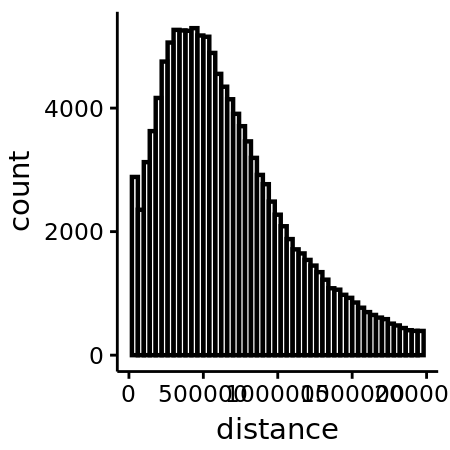

In [9]:
options(repr.plot.width = 1.5,repr.plot.height = 1.5,repr.plot.res= 300)
p <- diff_sig %>% mutate(distance = start2 - start1) %>% gghistogram(x="distance",bins=50) + theme_Publication()
p
p %>% ggplot2::ggsave(width = 1.5,height = 1.5,dpi=300,filename = "di_distribution.pdf")

In [19]:
24815 / 123728

[1] 0.2005609

In [18]:
diff_sig %>% mutate(distance = start2 - start1) %>% filter(distance > 1000000) 
#%>% group_by(distance) %>% summarise(count = n()) %>% arrange(desc(count))

chrom1,start1,end1,chrom2,start2,end2,pv,FDR,diff,pos,mat1_mean_all,mat2_mean_all,distance
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
chr1,4970000,4990000,chr1,6130000,6150000,0.0010231548,0.04467134,-0.3023846,chr1_4980000_6140000,4.715622,5.580506,1160000
chr1,7410000,7430000,chr1,8850000,8870000,0.0011410031,0.04716501,0.2522483,chr1_7420000_8860000,5.246773,4.455622,1440000
chr1,7430000,7450000,chr1,9250000,9270000,0.0005560433,0.03264845,0.1802668,chr1_7440000_9260000,5.093645,4.411481,1820000
chr1,7430000,7450000,chr1,9270000,9290000,0.0009495506,0.04293661,0.1831684,chr1_7440000_9280000,4.987987,4.312025,1840000
chr1,7450000,7470000,chr1,9250000,9270000,0.0001466814,0.01609127,0.2029230,chr1_7460000_9260000,5.159432,4.413884,1800000
chr1,7450000,7470000,chr1,9270000,9290000,0.0006729592,0.03600598,0.1972926,chr1_7460000_9280000,5.041969,4.333995,1820000
chr1,7470000,7490000,chr1,9230000,9250000,0.0008628176,0.04089583,0.2025316,chr1_7480000_9240000,5.232359,4.490686,1760000
chr1,7470000,7490000,chr1,9250000,9270000,0.0002275634,0.02033393,0.2187907,chr1_7480000_9260000,5.128621,4.334365,1780000
chr1,7470000,7490000,chr1,9270000,9290000,0.0005457951,0.03232460,0.2083223,chr1_7480000_9280000,5.006872,4.270007,1800000


In [9]:
Idents(hires)<-hires$celltype
rnadiff <- FindMarkers(hires,`ident.1` = c("Ex1"),`ident.2`=c("In1"))
rnadiff <- rnadiff %>% rownames_to_column("name") %>% left_join(mm10 %>% select(chrom,start,end,name)) %>% select(chrom,start,end,name,avg_log2FC,p_val_adj)

Joining, by = "name"


In [10]:
head(diff_filter)

chrom1,start1,end1,chrom2,start2,end2,pv,FDR,diff,pos,mat1_mean_all,mat2_mean_all
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
chr1,2570000,2590000,chr1,2590000,2610000,0.00013786443,0.01557285,0.2260244,chr1_2580000_2600000,1.067441,1.0289354
chr1,2590000,2610000,chr1,2610000,2630000,0.00040992581,0.02778709,0.2726851,chr1_2600000_2620000,1.073500,1.0213356
chr1,2630000,2650000,chr1,2670000,2690000,0.00026604532,0.02208072,0.2288568,chr1_2640000_2680000,1.964396,1.8824247
chr1,2730000,2750000,chr1,2750000,2770000,0.00089897716,0.04177856,0.3262067,chr1_2740000_2760000,1.063181,0.9986886
chr1,3730000,3750000,chr1,3750000,3770000,0.00007324521,0.01110155,0.3618417,chr1_3740000_3760000,1.075932,1.0028349
chr1,3830000,3850000,chr1,3870000,3890000,0.00051932050,0.03148070,0.3404818,chr1_3840000_3880000,1.750605,1.5890934


Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“Removed 586 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing missing values (geom_bar).”
Warning message:
“Removed 586 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing missing values (geom_bar).”


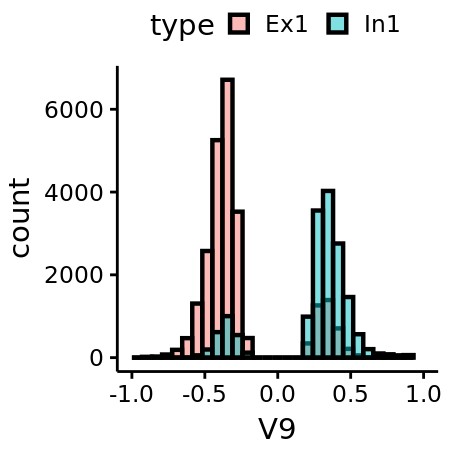

In [11]:
p <- bt.pairtobed(diff_filter,rnadiff %>% filter(p_val_adj < 0.01)) %>% mutate(type = ifelse(sign(V17) == 1, "Ex1","In1")) %>%mutate(V9 = - V9)%>%  gghistogram(x="V9",fill="type") +
theme_Publication() + scale_x_continuous(limits = c(-1,1))
p
p %>% ggplot2::ggsave(width = 1.5,height = 1.5,dpi=300,filename = "markergene_enricn_on_negative_di.pdf")

In [12]:
set.seed(42)
randomlengths <- c()
for (seed in seq(1,100)){
    set.seed(seed)
    randomdi <- diff_all %>% sample_n(10000)
    randomlength <- bt.pairtobed(randomdi %>% mutate(rank = 0),rnadiff%>% head(200))%>% mutate(type = "Random") %>% pull(V10) %>% unique() %>% length()
    randomlengths <- c(randomlengths,randomlength)
}
b = round(mean(randomlengths))
enrichment_df <- bt.pairtobed(diff_sig %>% arrange(FDR) %>% mutate(rank = row_number()),rnadiff%>% head(200))%>% 
    mutate(type = "DI") %>% mutate(group = floor(V13 / 10000)) %>% group_by(group,type) %>% summarise(count = length(unique(V10))) 
enrichment_df <- enrichment_df %>% filter(group != 14)

test_wrapper <- function(a,b){
    res <- fisher.test(t(matrix(c(a,b,(10000-a),(10000-b)),2)))
    return(list(c(res$estimate[[1]] ,res$conf.int,res$p.value)))
}

enrichment_df <- enrichment_df %>% rowwise() %>% mutate(res = test_wrapper(count,b)) %>% 
    separate(res,into = c("OR","low","high","pv"),sep=",") %>% 
    mutate_at(c("OR","low","high","pv"),function(x) as.numeric(str_replace_all(x,pattern = "[c()]",""))) #%>% 
#    ggplot() + geom_bar(aes(x=count))

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


In [13]:
p <- enrichment_df%>% filter(group!=12) %>% ggplot(aes(x=group,y=OR)) + geom_bar(stat = "identity",fill="#bdbdbd") + 
    geom_errorbar(aes(ymin=low, ymax=high), width=.2) + 
    geom_hline(aes(yintercept=1),linetype='dashed') +
    theme_Publication()  + xlab("Ranked DI group")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


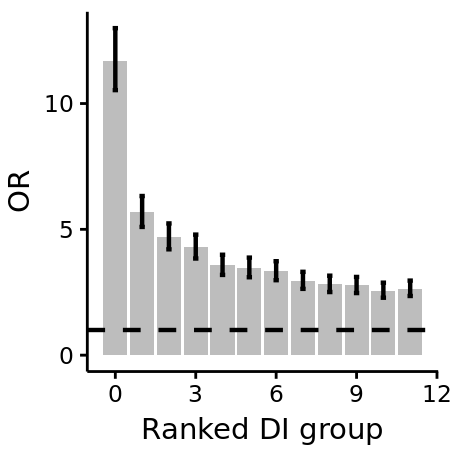

In [14]:
p

In [15]:
p %>% ggplot2::ggsave(width = 1.5,height = 1.5,dpi=300,filename = "di_markergene_enrich.pdf")

In [16]:
## DI 更倾向于富集在diff > 0 的 marker gene 上, 也就是interaction 变弱表达增加。# 

In [17]:
set.seed(42)
randomlengths <- c()
for (seed in seq(1,20)){
    set.seed(seed)
    randomdi <- diff_all %>% sample_n(10000)
    randomlength <- bt.pairtobed(randomdi %>% mutate(rank = 0),rnadiff %>% filter(avg_log2FC > 0) %>% head(100))%>% mutate(type = "Random") %>% pull(V10) %>% unique() %>% length()
    randomlengths <- c(randomlengths,randomlength)
}
b = round(mean(randomlengths))

enrichment_df_pos <- bt.pairtobed(diff_sig %>% arrange(FDR) %>% filter(diff > 0) %>% mutate(rank = row_number()),rnadiff %>% filter(avg_log2FC > 0) %>% head(100))%>% 
    mutate(type = "pos") %>% mutate(group = floor(V13 / 10000)) %>% group_by(group,type) %>% summarise(count = length(unique(V10))) %>% ungroup()
enrichment_df_neg <- bt.pairtobed(diff_sig %>% arrange(FDR) %>% filter(diff < 0) %>% mutate(rank = row_number()),rnadiff %>% filter(avg_log2FC > 0) %>% head(100))%>% 
    mutate(type = "neg") %>% mutate(group = floor(V13 / 10000)) %>% group_by(group,type) %>% summarise(count = length(unique(V10))) %>% ungroup()
compare_ex <- rbind(enrichment_df_pos,enrichment_df_neg)

compare_ex <- compare_ex %>% rowwise() %>% mutate(res = test_wrapper(count,b)) %>% 
    separate(res,into = c("OR","low","high","pv"),sep=",") %>% 
    mutate_at(c("OR","low","high","pv"),function(x) as.numeric(str_replace_all(x,pattern = "[c()]","")))

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


In [18]:
compare_ex %>% mutate(type = ifelse(type == "pos","Neg.","Pos.")) -> compare_ex

In [19]:
compare_ex %>% filter(group <5) %>%  ggplot(aes(x=group,y=OR,fill=type,group=type)) + 
    geom_bar(position="dodge",stat = "identity") + 
    geom_errorbar(aes(ymin=low, ymax=high),position=position_dodge(width=0.9),width=0.3) + 
    geom_hline(aes(yintercept=1),linetype='dashed') +
    scale_fill_manual(values=c("#fc8d59","#91bfdb")) + 
    theme_Publication() + theme(legend.position = "right",legend.direction = "vertical") -> p

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


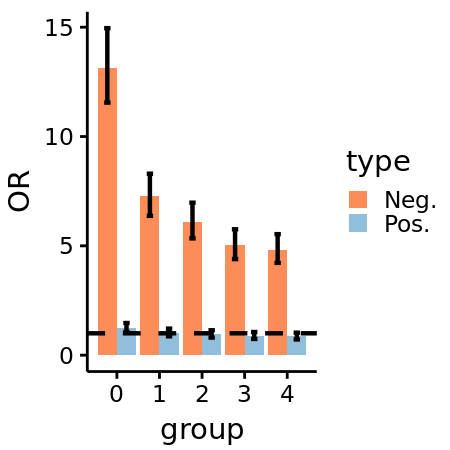

In [20]:
p

In [21]:
p %>% ggsave(width = 1.5,height = 1.5,dpi=300,filename = "ex1_markergene_enrich.pdf")

In [22]:
randomlengths <- c()
for (seed in seq(1,20)){
    set.seed(seed)
    randomdi <- diff_all %>% sample_n(10000)
    randomlength <- bt.pairtobed(randomdi %>% mutate(rank = 0),rnadiff %>% filter(avg_log2FC > 0) %>% head(100))%>% mutate(type = "Random") %>% pull(V10) %>% unique() %>% length()
    randomlengths <- c(randomlengths,randomlength)
}
b = round(mean(randomlengths))

enrichment_df_pos <- bt.pairtobed(diff_sig %>% arrange(FDR) %>% filter(diff > 0) %>% mutate(rank = row_number()),rnadiff %>% filter(avg_log2FC < 0) %>% head(100))%>% 
    mutate(type = "pos") %>% mutate(group = floor(V13 / 10000)) %>% group_by(group,type) %>% summarise(count = length(unique(V10))) %>% ungroup()
enrichment_df_neg <- bt.pairtobed(diff_sig %>% arrange(FDR) %>% filter(diff < 0) %>% mutate(rank = row_number()),rnadiff %>% filter(avg_log2FC < 0) %>% head(100))%>% 
    mutate(type = "neg") %>% mutate(group = floor(V13 / 10000)) %>% group_by(group,type) %>% summarise(count = length(unique(V10))) %>% ungroup()
compare_in <- rbind(enrichment_df_pos,enrichment_df_neg)

compare_in <- compare_in %>% rowwise() %>% mutate(res = test_wrapper(count,b)) %>% 
    separate(res,into = c("OR","low","high","pv"),sep=",") %>% 
    mutate_at(c("OR","low","high","pv"),function(x) as.numeric(str_replace_all(x,pattern = "[c()]","")))

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


In [23]:
compare_in %>% mutate(type = ifelse(type == "pos","Pos","Neg")) -> compare_in

In [24]:
q <- compare_in %>% filter(group <5) %>%  ggplot(aes(x=group,y=OR,fill=type,group=type)) + 
    geom_bar(position="dodge",stat = "identity") + 
    geom_errorbar(aes(ymin=low, ymax=high),position=position_dodge(width=0.9),width=0.3) + 
    geom_hline(aes(yintercept=1),linetype='dashed') +
    scale_fill_manual(values=c("#fc8d59","#91bfdb")) + 
    theme_Publication() + ggtitle("")+
    theme(legend.position = "right",legend.direction = "vertical")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


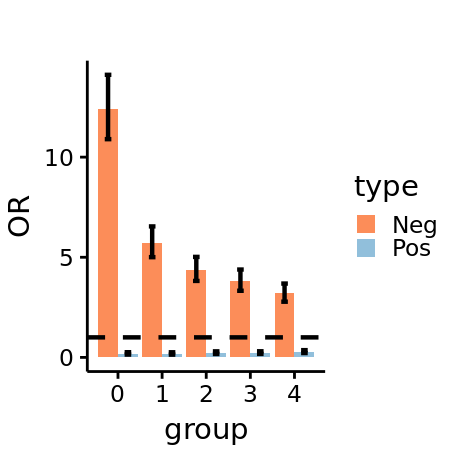

In [25]:
q

In [28]:
p %>% ggsave(width = 1.5,height = 1.5,dpi=300,filename = "In1_markergene_enrich.pdf")

# load data

In [20]:
hires <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/hires_mouse_emb_dev.new.rds")
hires <- subset(hires,subset = rmsd_20k < 1.5 & celltype != "mitosis" & celltype != "ExE ectoderm" & celltype != "ExE endoderm" & cellcycle_threshold != "M" & celltype != "blood")

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from cpg_umap_ to cpgumap_”
Warning message:
“Cannot add objects with duplicate keys (offending key: cpgumap_) setting key to original value 'cpg_umap_'”


In [21]:
alldi_raw <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/alldis.tsv.gz")
# restart 
di_filtered_all <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/alldis.filtered.tsv.gz")
mat_all <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/alldi_filtered_mat.rds.gz")

Rows: 5689793 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, pos, celltype
dbl (9): start1, end1, start2, end2, pv, FDR, diff, mat1_mean_all, mat2_mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 694384 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, 

In [51]:
set.seed(42) 
bin_annotation <- di_filtered_all %>% sample_n(10000) %>% select(celltype,pos) %>% arrange(celltype)
bins_select <- bin_annotation %>% pull(pos) %>% unique()
distance_on_di <- mat_all[,bins_select]
distance_on_di <- distance_on_di[c(TRUE,FALSE),] + distance_on_di[c(FALSE,TRUE),]
distance_on_di <- as.data.frame(distance_on_di)
rownames(distance_on_di) <- rownames(distance_on_di) %>% str_remove("mat")

In [52]:
library(future)
plan("multiprocess", workers = 40)


Attaching package: ‘future’


The following object is masked from ‘package:GenomicRanges’:

    values


The following object is masked from ‘package:S4Vectors’:

    values


Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”


In [53]:
mat <- distance_on_di %>% scale(center = T,scale = F) 
mat[is.na(mat)]<- 0
mat <- t(mat)
hires_di <- CreateSeuratObject(mat,assay = "di",min.cells = 0,min.features = 0)
hires_di
hires_di@meta.data <-hires_di@meta.data %>%rownames_to_column("cellname") %>%  left_join(hires[[]] %>% select(-orig.ident)) %>% mutate(temp = cellname) %>% column_to_rownames("temp")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
9941 features across 3599 samples within 1 assay 
Active assay: di (9941 features, 0 variable features)

Joining, by = "cellname"


In [54]:
options(future.globals.maxSize= 891289600*20)
hires_di %>% #ScaleData(do.center = T,do.scale = T,vars.to.regress = c("cellcycle_threshold")) %>% 
    ScaleData(do.center=F,do.scale=F) %>% 
    RunPCA(verbose = F,features = rownames(hires_di),npcs = 200) -> hires_di

In [55]:
hires_di %>% RunUMAP(dims = 1:40,verbose = F) -> hires_di

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [56]:
options(repr.plot.height = 4, repr.plot.width = 4,repr.plot.res = 200)
a <- DimPlot(hires_di,group.by = "celltype",cols = celltypeColors,pt.size = 0.05) + ggtitle("") + xlab("DI UMAP_1") + ylab("DI UMAP_2") + theme_Publication()+ NoLegend()
b <- DimPlot(hires_di,group.by = "cellcycle_threshold",cols = cellcyclecolors,pt.size = 0.05)+ ggtitle("") + xlab("DI UMAP_1") + ylab("DI UMAP_2") + theme_Publication()+ NoLegend()

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [57]:
a <- a + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) 
b <- b + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
               axis.text.y = element_blank()) 

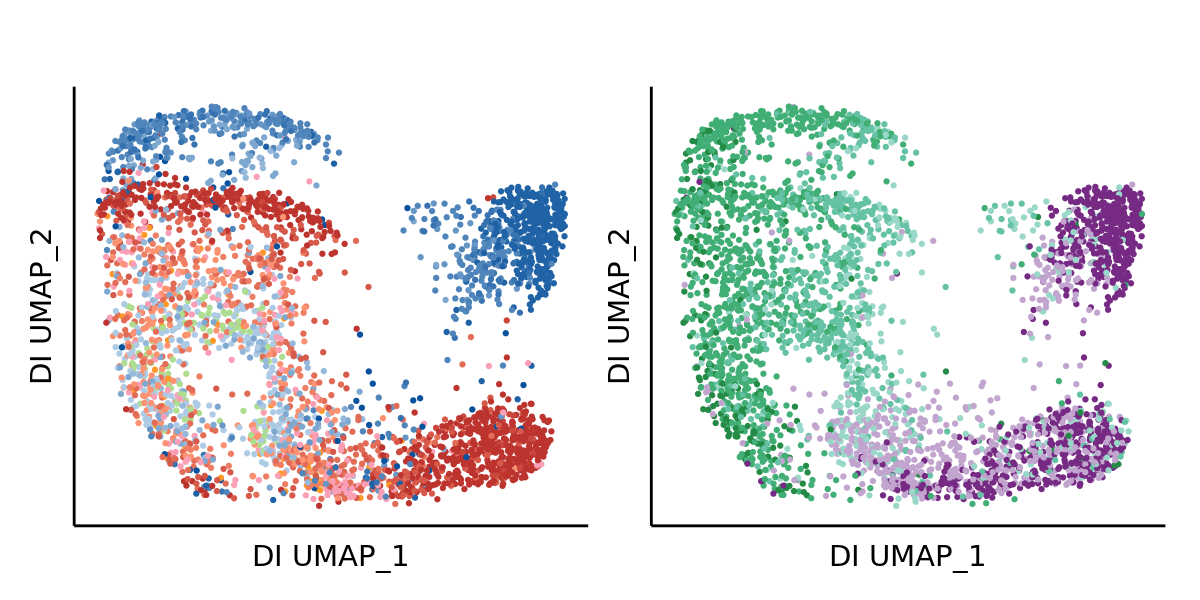

In [58]:
options(repr.plot.height = 2, repr.plot.width = 4,repr.plot.res = 300)
(a|b)

In [59]:
(a | b) %>% ggsave(filename = "di_reduction.pdf",height = 1.5,width = 3,dpi = 300)

# GADI related

In [24]:
allgadi_bedpe <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/hires_emb_gadi.tsv.gz")

Rows: 390252 Columns: 12
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chrom1, chrom2, name, pos, GADI_id
dbl (7): start1, end1, start2, end2, cor, pv, fdr_cor

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


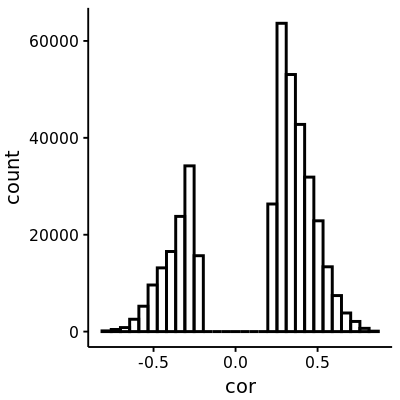

In [43]:
options(repr.plot.height = 2, repr.plot.width = 2 ,repr.plot.res = 200)
p <- allgadi_bedpe %>% mutate(cor = -cor) %>% gghistogram(x="cor") + theme_Publication()  
p
p %>% ggplot2::ggsave(filename = "gadi_histogram.pdf",width = 2,height = 2,dpi = 300)

In [44]:
DefaultAssay(hires) <- "SCT"

In [45]:
library(future)
plan("multiprocess", workers = 10)

In [46]:
options(scipen = 3)

In [47]:
Idents(hires)<-hires$celltype
rnadiff <- FindAllMarkers(hires)
#rnadiff <- rnadiff %>% rownames_to_column("name") %>% left_join(mm10 %>% select(chrom,start,end,name)) #%>% select(chrom,start,end,name,avg_log2FC,p_val_adj)

Calculating cluster neural ectoderm

Calculating cluster ExE mesoderm

Calculating cluster epithelial cells

Calculating cluster early mesenchyme

Calculating cluster early mesoderm

Calculating cluster endoderm

Calculating cluster epiblast and PS

Calculating cluster NMP

Calculating cluster neural tube

Calculating cluster radial glias

Calculating cluster oligodendrocytes and progenitors

Calculating cluster mix late mesenchyme

Calculating cluster early neurons

Calculating cluster schwann cell precursors

Calculating cluster intermediate mesoderm

Calculating cluster notochord

Calculating cluster myocytes



In [48]:
raw_rna_diff <- rnadiff 

In [49]:
raw_rna_diff -> rnadiff 

In [50]:
rnadiff <- rnadiff %>% rename(gene="name")  %>% left_join(mm10 %>% select(chrom,start,end,name)) #%>% select(chrom,start,end,name,avg_log2FC,p_val_adj)

Joining, by = "name"


In [51]:
rnadiff <- rnadiff %>% filter(p_val_adj< 0.01)%>% group_by(cluster) %>% arrange(p_val_adj) %>%
    dplyr::slice(1:200) %>% select(chrom,start,end,name,avg_log2FC,p_val_adj) %>% na.omit() %>% ungroup() %>% select(-cluster)

Adding missing grouping variables: `cluster`


In [52]:
rnadiff <- rnadiff %>% select(chrom,start,end,name) %>% unique()

In [53]:
rnadiff %>% pull(name) -> topmarkers

In [54]:
set.seed(42)
randomlengths <- c()
for (seed in seq(1,20)){
    set.seed(seed)
    randomdi <- diff_all %>% sample_n(30000)
    randomlength <- dim(bt.pairtobed(randomdi %>% mutate(rank = 0),rnadiff) %>% mutate(type = "Random"))[1]
    randomlengths <- c(randomlengths,randomlength)
}
b = round(mean(randomlengths))

enrichment_df <- allgadi_bedpe %>% arrange(fdr_cor) %>%  mutate(type = "GADI") %>% arrange()%>% mutate(group = floor(row_number() / 30000)) %>%  
        filter(name %in% topmarkers) %>% group_by(group,type) %>% summarise(count = n()) 
enrichment_df <- enrichment_df #%>% filter(group != 14)

test_wrapper <- function(a,b){
    res <- fisher.test(t(matrix(c(a,b,(30000-a),(30000-b)),2)))
    return(list(c(res$estimate[[1]] ,res$conf.int,res$p.value)))
}

enrichment_df <- enrichment_df %>% rowwise() %>% mutate(res = test_wrapper(count,b)) %>% 
    separate(res,into = c("OR","low","high","pv"),sep=",") %>% 
    mutate_at(c("OR","low","high","pv"),function(x) as.numeric(str_replace_all(x,pattern = "[c()]",""))) #%>% 
   #ggplot() + geom_bar(aes(x=count))

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


In [55]:
enrichment_df

group,type,count,OR,low,high,pv
<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,GADI,25884,18.33285067,17.57589701,19.12778379,0
1,GADI,22584,8.87651510,8.55186122,9.21132994,0
2,GADI,21290,7.12626221,6.87268501,7.38836860,0
3,GADI,21216,7.04136536,6.79346124,7.29899817,0
4,GADI,20781,6.57157197,6.34098827,6.81285531,0
5,GADI,19997,5.82804285,5.62472388,6.03909511,0
6,GADI,18861,4.93637258,4.76570891,5.11362047,0
7,GADI,18399,4.62369118,4.46487131,4.78806668,0
8,GADI,18124,4.44930125,4.29635897,4.60750700,0


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


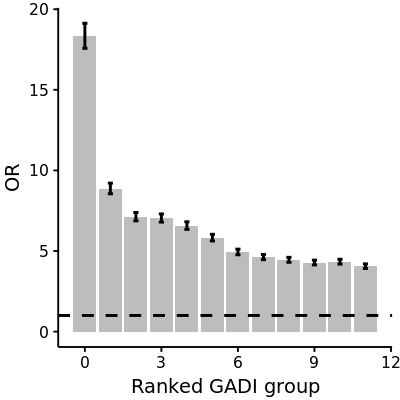

In [56]:
p <- enrichment_df %>% dplyr::slice(1:12)%>% ggplot(aes(x=group,y=OR)) + geom_bar(stat = "identity",fill="#bdbdbd") + 
    geom_errorbar(aes(ymin=low, ymax=high), width=.2) + 
    geom_hline(aes(yintercept=1),linetype='dashed') +
    theme_Publication()  + xlab("Ranked GADI group")
p

In [57]:
p %>% ggsave(width = 1.5,height = 1.5,dpi=300,filename = "gadi_markergene_enrich.pdf")

In [59]:
options(repr.plot.height = 4, repr.plot.width = 4,repr.plot.res = 200)
mediannum <- allgadi_bedpe %>% group_by(name) %>% summarise(count = n()) %>% pull(count)%>% median
p <- allgadi_bedpe %>% group_by(name) %>% summarise(count = n()) %>% gghistogram(x="count") + 
    geom_vline(aes(xintercept=mediannum), linetype="dashed") + theme_Publication()

q <- allgadi_bedpe %>% group_by(pos) %>% summarise(count = n()) %>% gghistogram(x="count",bins=16)+ theme_Publication()

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [60]:
length(allgadi_bedpe%>% pull(pos) %>% unique())

[1] 223607

In [66]:
allgadi_bedpe %>% group_by(name) %>% summarise(count = n()) %>% summary

     name               count       
 Length:1955        Min.   :  11.0  
 Class :character   1st Qu.:  47.0  
 Mode  :character   Median : 117.0  
                    Mean   : 199.6  
                    3rd Qu.: 257.5  
                    Max.   :2057.0  

In [61]:
allgadi_bedpe %>% group_by(pos) %>% summarise(count = n()) %>% arrange(desc(count)) %>% group_by(count) %>% summarise(p =n()/length(allgadi_bedpe%>% pull(pos) %>% unique()))

count,p
<int>,<dbl>
1,0.61032973029
2,0.24218383145
3,0.07743496402
4,0.03026291663
5,0.01295576614
6,0.00869829656
7,0.00479859754
8,0.00834499814
9,0.00050087877


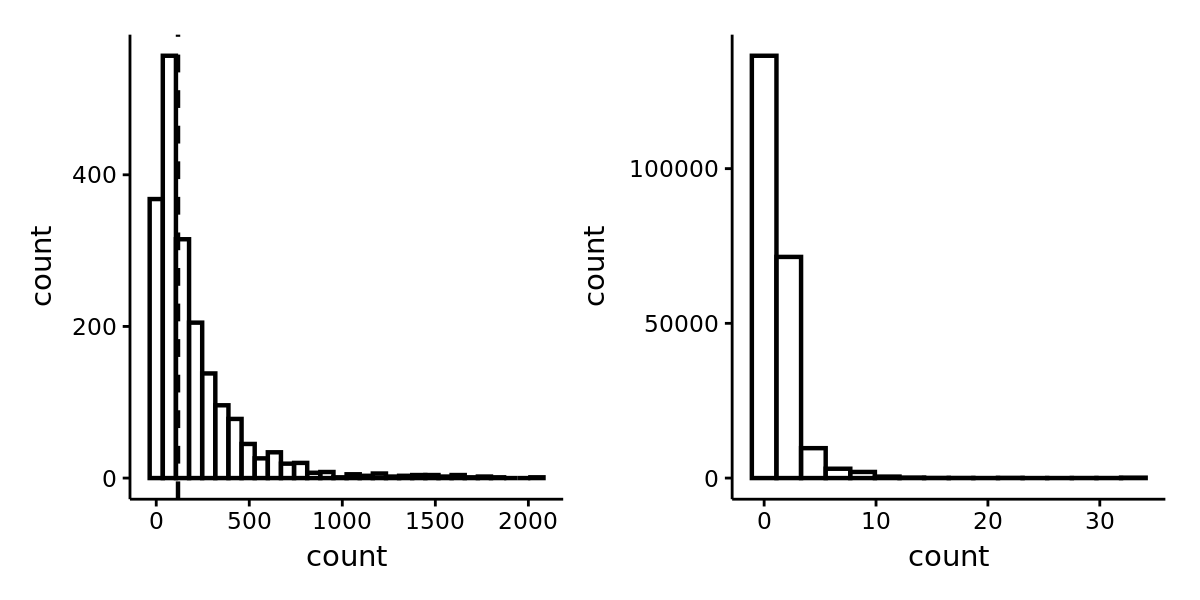

In [70]:
options(repr.plot.height = 2, repr.plot.width = 4,repr.plot.res = 300)
(p|q)
(p|q) %>% ggsave(width = 3,height = 1.5,dpi=300,filename = "gadi_histogram.pdf")

In [71]:
clustergadi <- allgadi_bedpe %>% group_by(pos) %>% mutate(count = n()) %>% filter(count > 5)
clustergadi <- clustergadi %>% group_by(name) %>% summarise(count = n()) %>% arrange(desc(count)) %>% mutate(rank = row_number())

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


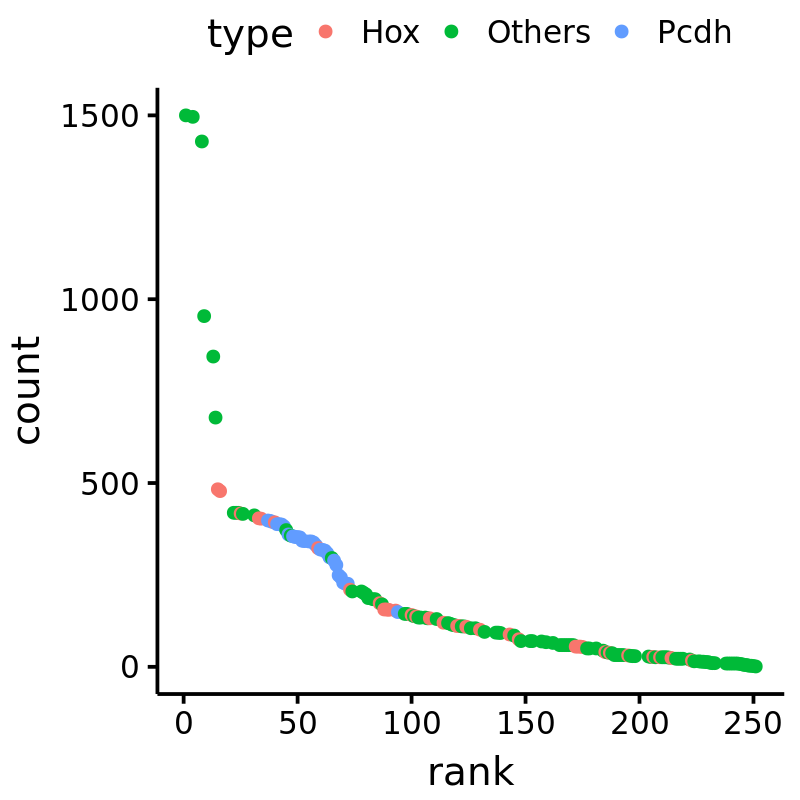

In [72]:
options(repr.plot.height = 2, repr.plot.width = 2,repr.plot.res = 400)
clustergadi %>% filter(!str_detect(name,"^Gm")) %>% mutate(type = ifelse(str_detect(name,"Hox"),"Hox",ifelse(
    str_detect(name,"Pcdh"),"Pcdh","Others"))) %>% 
    ggscatter(x="rank",y="count",color = "type",size = 0.5) + theme_Publication()

In [73]:
clustergadi %>% mutate(type = ifelse(str_detect(name,"Hox"),"Hox",ifelse(
    str_detect(name,"Pcdh"),"Pcdh","Else")
    )) %>% group_by(type) %>% summarise(count = sum(count))

type,count
<chr>,<int>
Else,36530
Hox,5451
Pcdh,9991


In [74]:
clustergadi %>% mutate(type = ifelse(str_detect(name,"Hox"),"Hox",ifelse(
    str_detect(name,"Pcdh"),"Pcdh","Else")
    )) %>% group_by(type) %>% summarise(count = sum(count) / (36530 + 5451 + 9991))

type,count
<chr>,<dbl>
Else,0.7028785
Hox,0.1048834
Pcdh,0.1922381


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


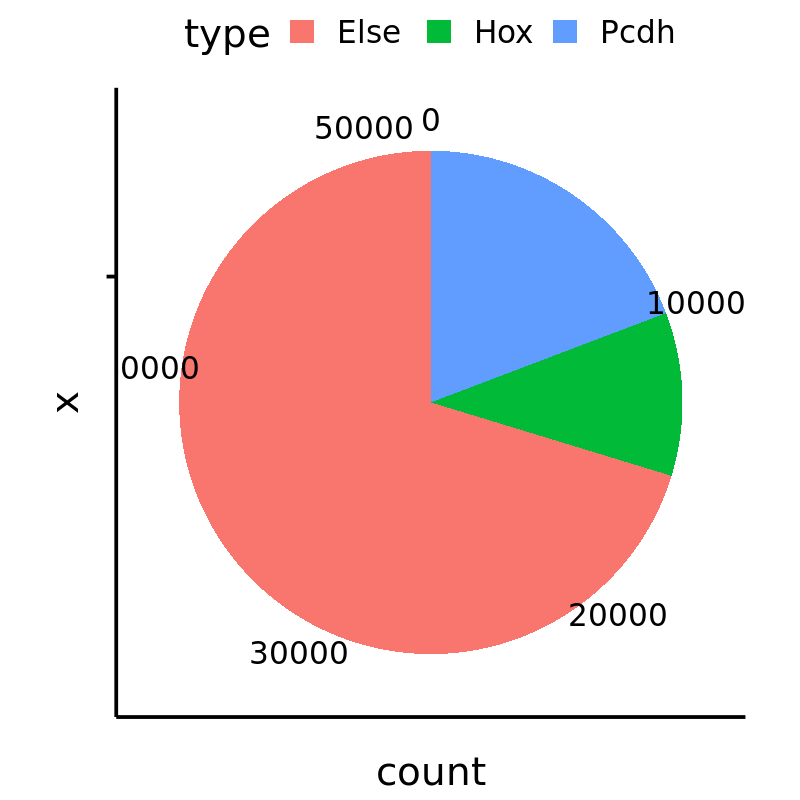

In [94]:
p <- clustergadi %>% mutate(type = ifelse(str_detect(name,"Hox"),"Hox",ifelse(
    str_detect(name,"Pcdh"),"Pcdh","Else")
    )) %>% group_by(type) %>% summarise(count = sum(count)) %>% 
    ggplot(aes(x="", y=count, fill=type)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) + theme_Publication()# + NoLegend() 
p
p%>% ggsave(width = 1.5,height = 1.5,dpi=300,filename = "gadi_cluster_pie.pdf")

In [75]:
library(ggbio)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Need specific help about ggbio? try mailing 
 the maintainer or visit https://lawremi.github.io/ggbio/


Attaching package: 'ggbio'


The following objects are masked from 'package:ggplot2':

    geom_bar, geom_rect, geom_segment, ggsave, stat_bin, stat_identity,
    xlim




In [76]:
genome_coord = "chr6:50,500,000-53,500,000"

In [77]:
startc = 50500000
endc = 53500000
#gene = "Dcc"
options(repr.plot.width = 7,repr.plot.height = 3,repr.plot.res = 200)

P <- allgadi_bedpe %>% filter(chrom1 == "chr6",str_detect(name,"Hox"))%>% group_by(pos) %>% mutate(count = n()) %>% filter(count > 5) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

Adding missing grouping variables: `pos`
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


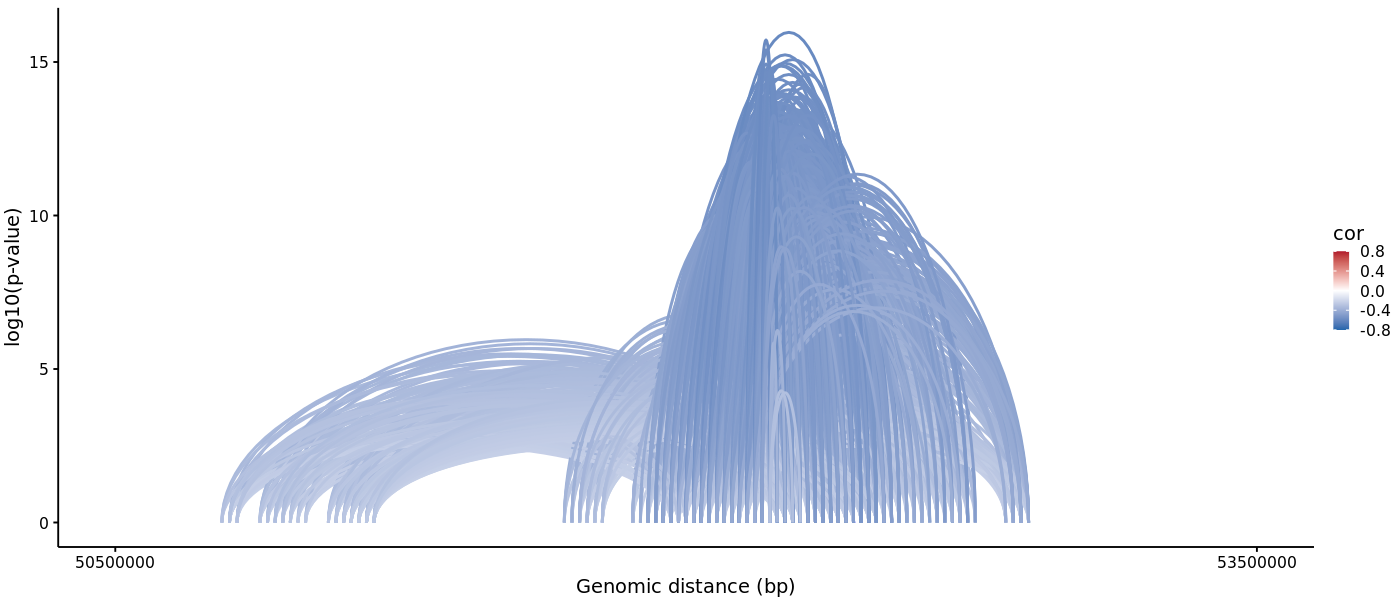

In [78]:
P

In [79]:
pdf("hoxcluster.pdf", width = 2.5, height = 1)
P
dev.off() 

png 
  2

In [99]:
startc = 74500000
endc = 80000000
#gene = "Dcc"
options(repr.plot.width = 7,repr.plot.height = 3,repr.plot.res = 200)

P <- allgadi_bedpe %>% filter(chrom1 == "chr6",)%>% group_by(pos) %>% mutate(count = n()) %>% filter(count > 5) %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,cor) %>% mutate(cor = -cor)  %>% GRanges() %>% ggplot() + geom_arch(aes(color = cor, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.8,0.8))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 

Adding missing grouping variables: `pos`
Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


Warning message:
"Removed 313248 row(s) containing missing values (geom_path)."


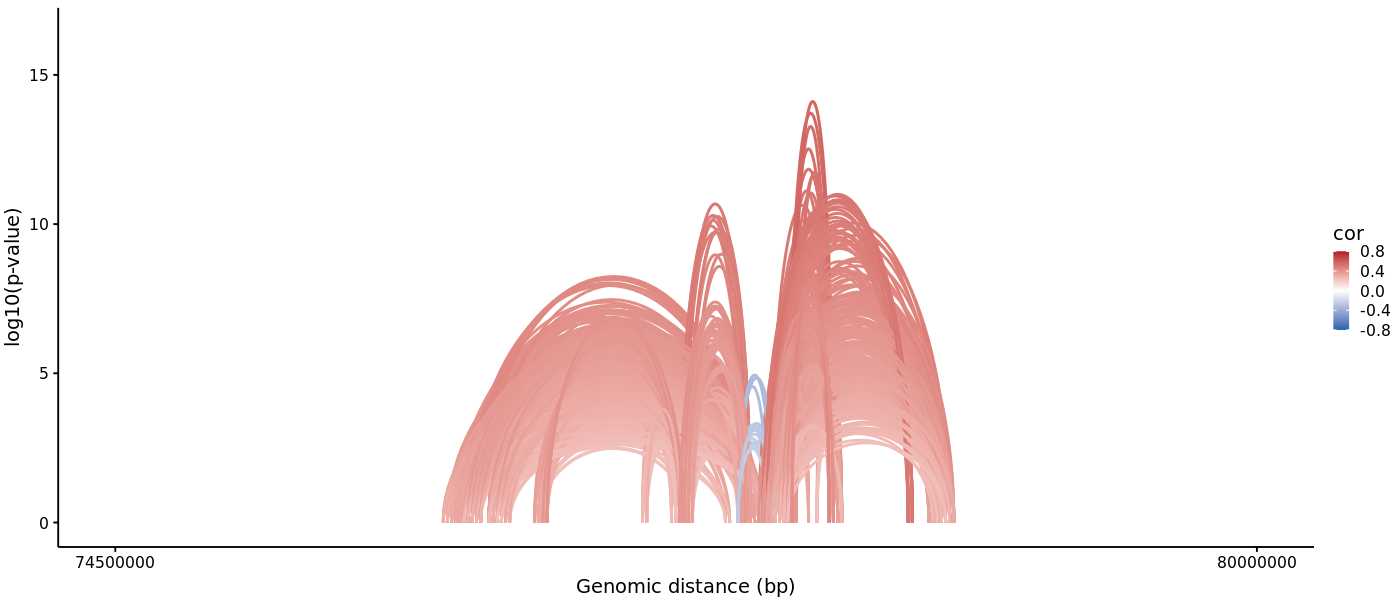

In [100]:
P

In [101]:
pdf("hoxcluster.pdf", width = 2.5, height = 1)
P
dev.off() 

Warning message:
"Removed 313248 row(s) containing missing values (geom_path)."


png 
  2

In [102]:
mm10_tss <- mm10 %>% mutate(tss = ifelse(strand =="+",start,end))%>% mutate(end = tss + 1) %>% select(chrom,tss,end,name) %>% mutate(end = tss + 1)

Joining, by = "name"
Warning message:
"Using `bins = 30` by default. Pick better value with the argument `bins`."


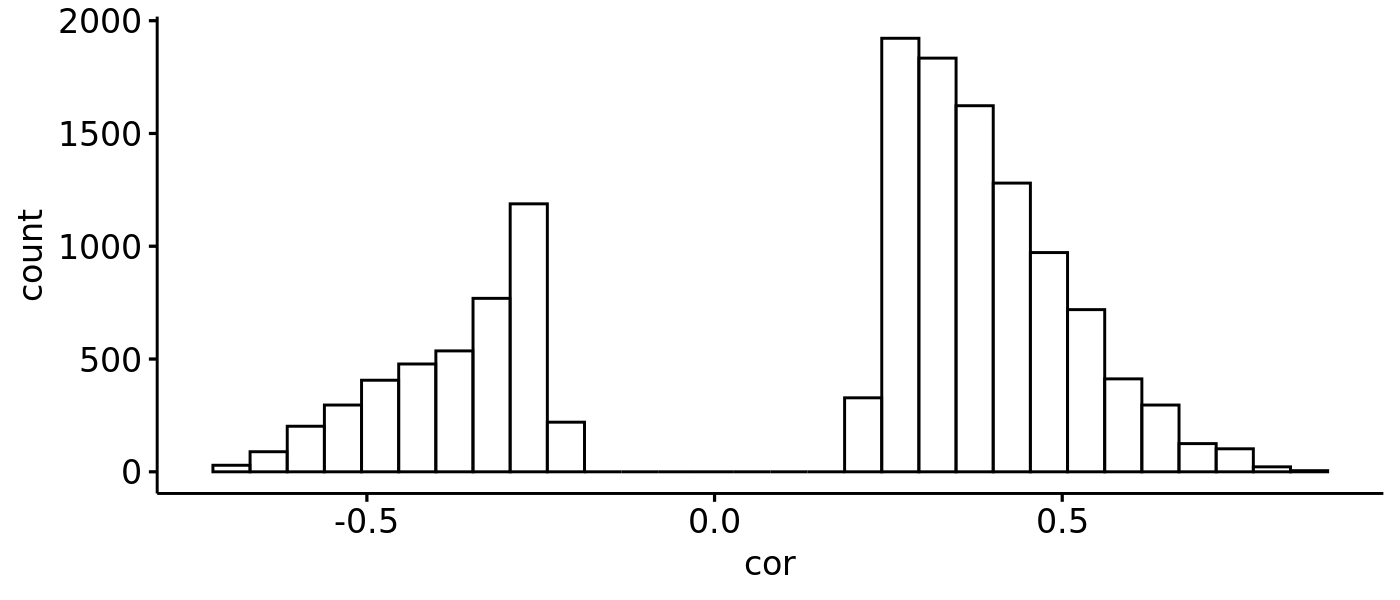

In [104]:
p <- allgadi_bedpe %>% mutate(cor = -cor) %>% left_join(mm10_tss) %>% filter((tss >= start1 & tss <= end1) | (tss >= start2 & tss <= end2) ) %>% 
    gghistogram(x="cor")
p 

In [105]:
(p+theme_Publication()) %>% ggplot2::ggsave(width = 1.5,height = 1.5,dpi=300,filename = "gadi_tss_histo.pdf")

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


In [34]:
136474 / 223607

[1] 0.6103297

In [33]:
allgadi_bedpe %>% group_by(pos) %>% summarise(count = n()) %>% filter(count == 1)

pos,count
<chr>,<int>
chr1-10200000-10540000,1
chr1-10200000-10560000,1
chr1-10200000-10580000,1
chr1-10200000-10600000,1
chr1-10200000-10640000,1
chr1-10200000-10800000,1
chr1-10200000-10820000,1
chr1-10260000-10720000,1
chr1-10280000-10720000,1


In [ ]:
tss